# **NAME : Affan Zulfiqar**
# **REG ID : B22F0144AI050**
# **Course : ANN LAB 10**
# **Section : AI22F-Bllue**

### **Importing Libraries**

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
warnings.filterwarnings("ignore")

### **Load the dataset and normalize**

In [5]:
url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv'
df = pd.read_csv(url)
df['Month'] = pd.to_datetime(df['Month'])
df.set_index('Month', inplace=True)

# Normalize the data
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(df[['Passengers']])

### **Preprocessing**
It creates input-output pairs from scaled time-series data using a sliding window (seq_len=10) and splits the dataset into training and testing sets. The inputs are then reshaped to 3D format for compatibility with RNN models.

In [50]:
# Create sequences for time-series data
def create_sequences(data, seq_len=10):
    X, y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:i+seq_len])
        y.append(data[i+seq_len])
    return np.array(X), np.array(y)

seq_len = 10
X, y = create_sequences(data_scaled, seq_len)

# Train-test split
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Reshape data for RNN
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

### **Model**
Builds a multi-layer RNN with customizable activation, optimizer, and units. Uses dropout for regularization and MSE loss for regression.

In [6]:
def build_rnn(activation='relu', optimizer='adam', units=50):
    model = Sequential([
        SimpleRNN(units, activation=activation, return_sequences=True, input_shape=(seq_len, 1)),
        Dropout(0.2),
        SimpleRNN(units // 2, activation=activation, return_sequences=True),
        Dropout(0.2),
        SimpleRNN(units // 2, activation=activation),
        Dense(1)
    ])

    # Select optimizer
    opt = {'adam': Adam, 'rmsprop': RMSprop, 'sgd': SGD}[optimizer](learning_rate=0.001)
    model.compile(optimizer=opt, loss='mse')
    return model

### **Training & Performance Evaluation**
It trains and evaluates RNNs with different activations, optimizers, and units. It prints and stores MAE, MSE, and RMSE for each configuration and shows a comparison in a sorted DataFrame.

In [7]:
# Initialize a list to store the results for comparison
evaluation_results = []

configs = [
    ('relu', 'adam', 64),
    ('tanh', 'rmsprop', 50),
    ('sigmoid', 'sgd', 32),
]

# Loop through each configuration and evaluate the models
for activation, optimizer, units in configs:
    print(f"\nTraining with {activation}, {optimizer}, {units} neurons")

    # Build and train the RNN
    model = build_rnn(activation, optimizer, units)
    history = model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=0)

    # Predict and rescale the predictions
    pred = model.predict(X_test)
    pred_rescaled = scaler.inverse_transform(pred)
    y_test_rescaled = scaler.inverse_transform(y_test)

    # Calculate MAE, MSE, and RMSE
    mae = mean_absolute_error(y_test_rescaled, pred_rescaled)
    mse = mean_squared_error(y_test_rescaled, pred_rescaled)
    rmse = np.sqrt(mse)

    # Print the metrics
    print(f"MAE: {mae:.4f}")
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")

    # Store the results for later comparison
    evaluation_results.append({
        'Activation': activation,
        'Optimizer': optimizer,
        'Units': units,
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse
    })

# Create a DataFrame for easy comparison
evaluation_df = pd.DataFrame(evaluation_results)
evaluation_df.sort_values(by='RMSE', ascending=True, inplace=True)



Training with relu, adam, 64 neurons
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step
MAE: 68.0805
MSE: 8154.1541
RMSE: 90.3004

Training with tanh, rmsprop, 50 neurons
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step
MAE: 49.3073
MSE: 4310.2072
RMSE: 65.6522

Training with sigmoid, sgd, 32 neurons
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step
MAE: 304.6863
MSE: 99150.0207
RMSE: 314.8810


### **Plot Evaluation Metrics for RNN Configurations**
This cell visualizes the MAE, MSE, and RMSE for each model configuration using bar charts for easy comparison.

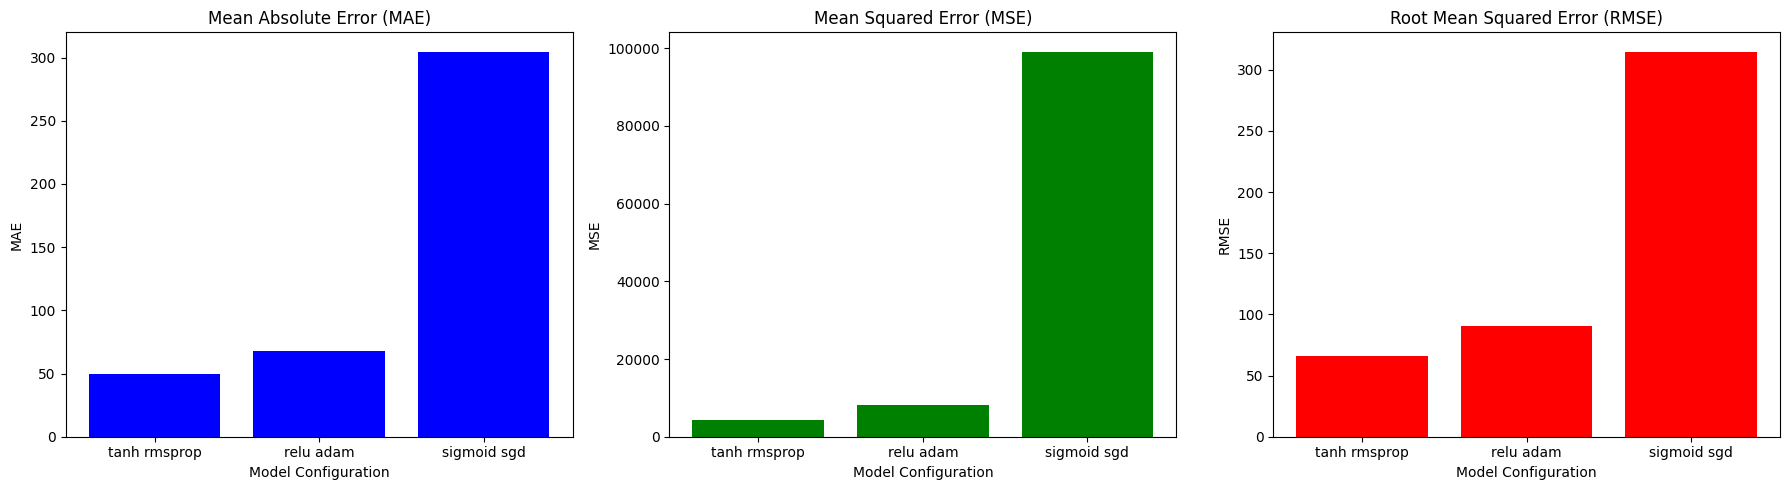

In [8]:
fig, ax = plt.subplots(1, 3, figsize=(18, 5))

# Extract configuration labels
config_labels = evaluation_df['Activation'] + " " + evaluation_df['Optimizer']

# Plot MAE
ax[0].bar(config_labels, evaluation_df['MAE'], color='blue')
ax[0].set_title('Mean Absolute Error (MAE)')
ax[0].set_xlabel('Model Configuration')
ax[0].set_ylabel('MAE')

# Plot MSE
ax[1].bar(config_labels, evaluation_df['MSE'], color='green')
ax[1].set_title('Mean Squared Error (MSE)')
ax[1].set_xlabel('Model Configuration')
ax[1].set_ylabel('MSE')

# Plot RMSE
ax[2].bar(config_labels, evaluation_df['RMSE'], color='red')
ax[2].set_title('Root Mean Squared Error (RMSE)')
ax[2].set_xlabel('Model Configuration')
ax[2].set_ylabel('RMSE')

plt.tight_layout()
plt.show()

## **Plot Actual vs Predicted Time-Series Values for RNN Models**
This cell trains an RNN for each configuration and visualizes the predicted values against the actual test values to assess how well each model captures trends.


Training with relu, adam, 64 neurons
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step


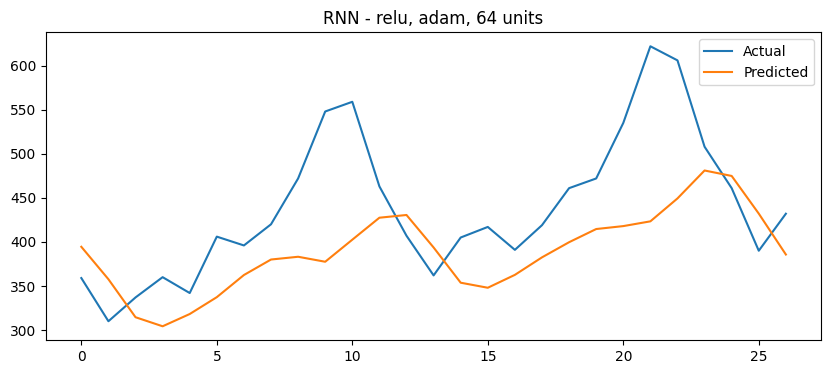


Training with tanh, rmsprop, 50 neurons


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step


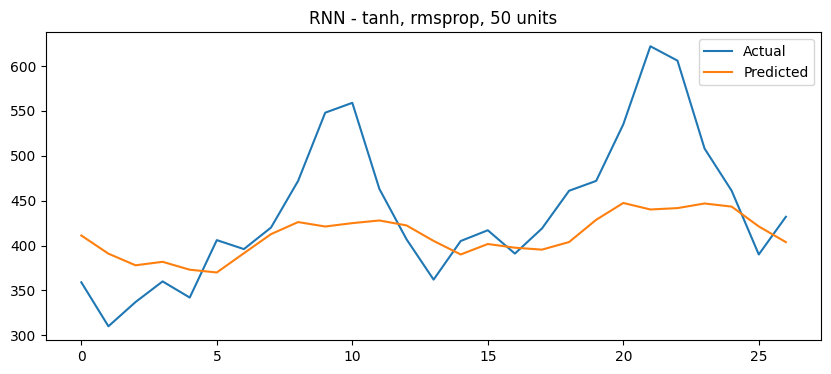


Training with sigmoid, sgd, 32 neurons


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step


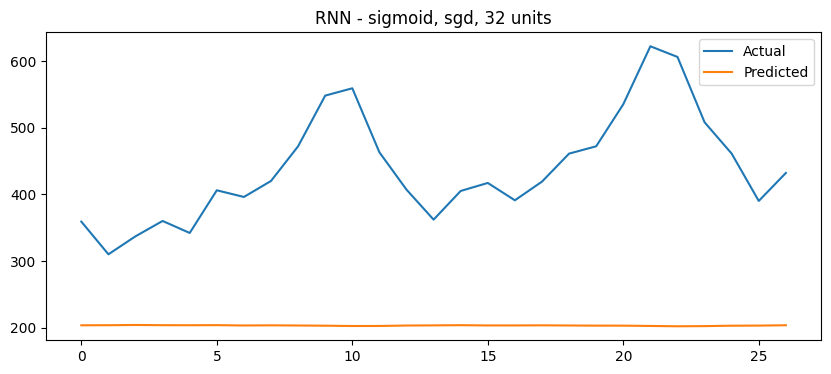

In [12]:
# Plot Predictions vs Actual Values
for activation, optimizer, units in configs:
    print(f"\nTraining with {activation}, {optimizer}, {units} neurons")
    model = build_rnn(activation, optimizer, units)
    history = model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=0)

    # Evaluate the model
    pred = model.predict(X_test)
    pred_rescaled = scaler.inverse_transform(pred)
    y_test_rescaled = scaler.inverse_transform(y_test)

    # Plot the actual vs predicted values
    plt.figure(figsize=(10, 4))
    plt.plot(y_test_rescaled, label='Actual')
    plt.plot(pred_rescaled, label='Predicted')
    plt.title(f'RNN - {activation}, {optimizer}, {units} units')
    plt.legend()
    plt.show()


# **Text Generator RNN**

In [45]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense
from tensorflow.keras.preprocessing.sequence import pad_sequences
import random

**Defining Input Text and Character Set**

In [46]:
corpus = [
    "Hi! This is Affan Zulfiqar",
    "A passionate learner of Machine Learning",
    "I enjoy working on deep learning models",
    "Deep learning is an exciting field",
    "Machine learning can be challenging yet rewarding",
    "Learning new algorithms is fun",
    "I love working with data",
    "Neural networks are powerful models",
    "Python is my favorite programming language",
    "Data science combines statistics and programming"
]

# Combine the corpus into one long string
text = " ".join(corpus)

# Create a sorted list of unique characters from the text
chars = sorted(list(set(text)))

# Create mappings from character to index and vice versa
char_to_index = {char: i for i, char in enumerate(chars)}
index_to_char = {i: char for i, char in enumerate(chars)}

print("Character to Index Mapping:", char_to_index)
print("List of Unique Characters:", chars)

Character to Index Mapping: {' ': 0, '!': 1, 'A': 2, 'D': 3, 'H': 4, 'I': 5, 'L': 6, 'M': 7, 'N': 8, 'P': 9, 'T': 10, 'Z': 11, 'a': 12, 'b': 13, 'c': 14, 'd': 15, 'e': 16, 'f': 17, 'g': 18, 'h': 19, 'i': 20, 'j': 21, 'k': 22, 'l': 23, 'm': 24, 'n': 25, 'o': 26, 'p': 27, 'q': 28, 'r': 29, 's': 30, 't': 31, 'u': 32, 'v': 33, 'w': 34, 'x': 35, 'y': 36}
List of Unique Characters: [' ', '!', 'A', 'D', 'H', 'I', 'L', 'M', 'N', 'P', 'T', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y']


**Prepare Sequences for Training**

In [47]:
seq_length = 10
step = 1

input_sequences = []
target_chars = []

# Generate sequences from the input text
for i in range(0, len(text) - seq_length, step):
    input_sequences.append([char_to_index[char] for char in text[i:i + seq_length]])
    target_chars.append(char_to_index[text[i + seq_length]])

X = np.array(input_sequences)
y = tf.keras.utils.to_categorical(target_chars, num_classes=len(chars))

print(f"Number of Sequences: {len(X)}")

Number of Sequences: 366


**Training Model**

In [48]:
def build_text_generator_rnn():
    model = Sequential([
        Embedding(input_dim=len(chars), output_dim=50, input_length=seq_length),
        SimpleRNN(256, return_sequences=True),
        SimpleRNN(128),
        Dense(len(chars), activation='softmax')
    ])
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    return model

model = build_text_generator_rnn()
model.summary()

history = model.fit(X, y, batch_size=64, epochs=100, verbose=1)

Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_10 (Embedding)             │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_34 (SimpleRNN)            │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_35 (SimpleRNN)            │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 3.5659
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 2.9807
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 2.7555
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 2.5071
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 2.3202
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 2.0825
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 1.8834
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 1.7024
Epoch 9/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 1.4928
Epoch 10/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 1.3997
Epoch 11/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 1.2268
Epoch 12/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 1.1253
Epoch 13/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 1.0352
Epoch 14/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.9418
Epoch 15/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.8248
Epoch 16/100
6/6 ━━

**Generate Text Function**

In [54]:
def sample(preds, temperature=1.0):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds + 1e-8) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    return np.random.choice(len(preds), p=preds)

def generate_text(seed_text, length=100, temperature=0.5):
    generated = seed_text
    for _ in range(length):
        input_seq = [char_to_index.get(c, 0) for c in generated[-seq_length:]]
        input_seq = pad_sequences([input_seq], maxlen=seq_length)
        pred = model.predict(input_seq, verbose=0)[0]
        next_idx = sample(pred, temperature)
        generated += index_to_char[next_idx]
    return generated

seed = " I enjoy"
print("\nGenerated Text (Temp=0.5):\n")
generated_text = generate_text(seed, length=40, temperature=0.5)
print(generated_text)



Generated Text (Temp=0.5):

 I enjoy working on deep learning models Deep le
